In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from scipy.io import loadmat
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
import time

In [ ]:
# load data from matlab
data = loadmat('/content/gdrive/MyDrive/keypoint/LSTM_training.mat')
labels = loadmat('/content/gdrive/MyDrive/keypoint/labels.mat')

In [ ]:
all_label = labels['ans'].T[0]-1
action_seq = data['kf_filtered_sequences']

# ST-GCN

## Graph

In [ ]:
class Graph():
    def __init__(self):
        self.num_node = 3
        self.get_edge()
        self.hop_dis = self.get_hop_distance()
        self.get_adjacency()

    def __str__(self):
        return self.A

    def get_edge(self):
        self_link = [(i,i) for i in range(self.num_node)] # I
        neighbor_link = [(1,0),(2,1)] # A
        self.edge = self_link + neighbor_link # A+I
        self.center = 1

    def get_adjacency(self, max_hop=1, dilation=1):
        valid_hop = range(0,max_hop+1,dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = self.normalize_digraph(adjacency)

        # strategy == 'uniform'
        A = np.zeros((1,self.num_node, self.num_node))
        A[0] = normalize_adjacency

        self.A = A

    def get_hop_distance(self,max_hop=1):
        num_node = self.num_node
        edge = self.edge
        A = np.zeros((num_node, num_node))
        for i, j in edge:
            A[j, i] = 1
            A[i, j] = 1

        # compute hop steps d:distance
        hop_dis = np.zeros((num_node, num_node)) + np.inf
        transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
        arrive_mat = (np.stack(transfer_mat) > 0)
        for d in range(max_hop, -1, -1):
            hop_dis[arrive_mat[d]] = d

        return hop_dis

    def normalize_digraph(self,A):
        Dl = np.sum(A, 0)
        num_node = A.shape[0]
        Dn = np.zeros((num_node, num_node))
        for i in range(num_node):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-1)

        AD = np.dot(A, Dn)

        return AD

## STGCN

In [ ]:
REGULARIZER = tf.keras.regularizers.l2(l=0.0001)

In [ ]:
class tgcn(tf.keras.Model):
    """ basic module for applying a graph convolution
        filters (int): Number of channels produced by the convolution
        kernel_size (int): Size of the graph convolving kernel
        Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_in, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_out, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format
        where
            :math:`N` is a batch size
            :math:`K` is the spatial kernel size
            :math:`T` is a length of the sequence
            :math:`V` is the number of graph nodes
            :math:`C` is the number of incoming channels
    """
    def __init__(self,filters, kernel_size,
                 t_kernel_size=1, t_stride=1, t_dilation=1,bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(
            filters*kernel_size,
            kernel_size=(t_kernel_size, 1),
            strides=(t_stride, 1),
            padding='same',
            dilation_rate=(t_dilation, 1),
            data_format='channels_first',
            use_bias=bias,
            kernel_regularizer=REGULARIZER)


    def call(self, x, A):

        assert A.shape[0] == self.kernel_size

        x = self.conv(x)
        n, c, t, v = x.shape
        x = tf.reshape(x, [n, self.kernel_size, c//self.kernel_size, t, v])
        x = tf.einsum('nkctv,kvw->nctw', x, A)
        return x,A

In [ ]:
class stgcn(tf.keras.Model):
    """
        filters (int): Number of channels produced by the convolution
        kernel_size (tuple): Size of the temporal convolving kernel and graph convolving kernel
        stride (int, optional): Stride of the temporal convolution. Default: 1
        dropout (int, optional): Dropout rate of the final output. Default: 0
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True`

        Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """
    def __init__(self,filters,kernel_size,stride=1,dropout=0,residual=True, ineqout=False):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1

        self.kernel_size = kernel_size # kernel_size=3

        self.gcn = tgcn(filters, kernel_size=kernel_size[1])

        self.tcn = tf.keras.Sequential(
            [tf.keras.layers.BatchNormalization(axis=1),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Conv2D(filters,
                                   kernel_size=[kernel_size[0], 1],
                                   strides=[stride, 1],
                                   padding='same',
                                   data_format='channels_first',
                                   kernel_regularizer=REGULARIZER),
            tf.keras.layers.BatchNormalization(axis=1),
            tf.keras.layers.Dropout(dropout)]
        )

        if not residual:
            self.residual = lambda x : 0
        elif stride == 1 and ineqout:
            self.residual = lambda x : x
        else:
            self.residual = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters,
                                       kernel_size=[1, 1],
                                       strides=[stride, 1],
                                       padding='same',
                                      data_format='channels_first',
                                       kernel_regularizer=REGULARIZER),
                tf.keras.layers.BatchNormalization(axis=1)
            ])

        self.act = tf.keras.layers.Activation('relu')

    def call(self, x, A):
        res = self.residual(x)
        x, A = self.gcn(x, A)
        x = self.tcn(x) + res
        x = self.act(x)
        return x, A

## SAG

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, in_dim, hid_dim):
        super(Attention, self).__init__()
        # trainable W_u and w_beta in Dense layer
        self.attention = tf.keras.Sequential([
            tf.keras.layers.Dense(hid_dim), # W_u*Z
            tf.keras.layers.Activation('tanh'), # u_k,j = tanh(W_u*z_k,j)
            tf.keras.layers.Dense(1) # w_beta*u_k,j
        ])

    def call(self, embeddings):
        e = self.attention(embeddings)
        return e

In [ ]:
class SAG(tf.keras.Model):
    """
    Spatial Attention Graph Convolutional Nets (SAG)

    Args:
        in_dim (int): Number of channels in the input datasets
        z_dim  (int): Dimensionality of output node features

    Shape:
        - Input: :math:`(N, in_dim, T_{in}, V_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes.
    """

    def __init__(self, in_dim, z_dim,beta_dim, edge_importance_weighting=None,dropout_gcn=0.3,dropout_feature=0.3):
        super(SAG,self).__init__()

        self.graph=Graph()

        self.A = tf.Variable(self.graph.A,
                             dtype=tf.float32,
                             trainable=False,
                             name='adjacency_matrix')
        # build network
        spatial_kernel_size = self.A.shape[0]
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size) # [9,3]

        # 3 layer ineqout: in_channels == out_channels
        self.STGCN_layers = [
            stgcn(64,kernel_size,1,ineqout=False), # t-stride 7->64
            stgcn(128,kernel_size,2,dropout=dropout_gcn,ineqout=False),# 64->128
            stgcn(z_dim,kernel_size,2,dropout=dropout_gcn,ineqout=(z_dim==128)) # 128->128
        ]
        # edge_importance_weighting=None
        self.edge_importance = [1] * len(self.STGCN_layers)

        self.spatial_attn = Attention(in_dim=z_dim, hid_dim=beta_dim)
        self.fcn = tf.keras.layers.Conv2D(z_dim, kernel_size=1,data_format='channels_first',kernel_regularizer=REGULARIZER)

        self.predict = tf.keras.Sequential([
            tf.keras.layers.Dropout(rate=dropout_feature),
            tf.keras.layers.Dense(units=2, activation="sigmoid", use_bias=True)
            ])

    def call(self, x):
        """
         N: batch_size
         C: num_channels
         T: num_frames
         V: num_joints
        """
        N,C,T,V = x.shape
        x = tf.transpose(x, perm=[0, 3, 1, 2])
        x = tf.reshape(x, shape=[N, V * C, T])
        x = tf.keras.layers.BatchNormalization(axis=1)(x)
        x = tf.reshape(x, shape=[N, V, C, T])
        x = tf.transpose(x, perm=[0, 2, 3, 1])
        x = tf.reshape(x, shape=[N, C, T, V])

        for gcn in self.STGCN_layers:
            x, _ = gcn(x, self.A)

        _, c, t, v = x.shape

        # feature = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_first')(x)
        x_pooled = tf.reduce_mean(x, axis=[2, 3], keepdims=True)

        feature = tf.squeeze(x_pooled, axis=2)
        feature = tf.transpose(feature, perm=[0, 2, 1]) # Z joint representation
        # attention
        e = self.spatial_attn(feature) # embedding = w_beta*u_k,j
        beta = tf.keras.activations.softmax(e, axis=1) # beta=softmax(e)
        feature = tf.matmul(tf.transpose(beta, perm=[0, 2, 1]), feature) # beta_k,j*z_k,j
        feature = tf.transpose(feature, perm=[0, 2, 1])
        feature = tf.expand_dims(feature , axis=-1) #V_k

        # prediction
        feature = self.fcn(feature)
        feature = tf.reshape(feature, [feature.shape[0], -1]) #(N,d)
        scores = self.predict(feature)
        return feature, beta, scores


## training

### build dataset

In [ ]:
def build_features(rawx, T_max=90):
    t = rawx.shape[1]
    fps = t/3.0  # 3s clip
    if t<T_max:
        # print(t, T_max)
        rawx = np.pad(rawx,((0,0),(0, T_max-rawx.shape[1])), mode = 'constant')

    df = pd.DataFrame(rawx.T, columns = ['x0','y0','x1','y1','x2','y2'])

    diff = df.diff()
    diff.iloc[0] = 0
    # xy features
    df['displacement_0'] = np.sqrt(diff['x0']**2 + diff['y0']**2)
    df['displacement_1'] = np.sqrt(diff['x1']**2 + diff['y1']**2)
    df['displacement_2'] = np.sqrt(diff['x2']**2 + diff['y2']**2)

    df['velocity_x0'] = diff['x0'] * fps
    df['velocity_x1'] = diff['x1'] * fps
    df['velocity_x2'] = diff['x2'] * fps

    df['velocity_y0'] = diff['y0'] * fps
    df['velocity_y1'] = diff['y1'] * fps
    df['velocity_y2'] = diff['y2'] * fps

    #new diff

    diff = df.diff()
    diff.iloc[0] = 0
    df['acceleration_x0'] = diff['velocity_x0'] * fps
    df['acceleration_x1'] = diff['velocity_x1'] * fps
    df['acceleration_x2'] = diff['velocity_x2'] * fps

    df['acceleration_y0'] = diff['velocity_y0'] * fps
    df['acceleration_y1'] = diff['velocity_y1'] * fps
    df['acceleration_y2'] = diff['velocity_y2'] * fps


    joint0 = ['x0','y0','velocity_x0','velocity_y0','acceleration_x0','acceleration_y0','displacement_0']
    joint1 = ['x1','y1','velocity_x1','velocity_y1','acceleration_x1','acceleration_y1','displacement_1']
    joint2 = ['x2','y2','velocity_x2','velocity_y2','acceleration_x2','acceleration_y2','displacement_2']


    return np.stack((df[joint0].T,df[joint1].T,df[joint2].T),axis=-1)

In [ ]:
# sequence class to load and vectorize batches of data
class Features(keras.utils.Sequence):
    def __init__(self, action_sequences,labels,batch_size):
        self.action_sequences = action_sequences
        self.batch_size = batch_size
        self.labels = tf.one_hot(labels, depth=2)


    def __len__(self):
        return math.ceil(len(self.action_sequences) / self.batch_size)


    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low + self.batch_size, len(self.action_sequences))
        batch_sequences = self.action_sequences[low:high]
        batch_label = self.labels[low:high]
        return np.array([
            build_features(sequence[0])
                for sequence in batch_sequences]), batch_label

### left leg data and label

In [ ]:
train = 800
div = 2219
val = 200
batch_size=64

train_label = all_label[:train]
val_label = all_label[train:train+val]
test_label = all_label[div-train:div]

# Instantiate data Sequences for each split left leg
train_generator = Features(action_seq[:train], train_label, batch_size)
valid_generator = Features(action_seq[train:train+val],val_label, batch_size)
test_generator = Features(action_seq[div-train:div],test_label, batch_size)

### train step

In [ ]:
channels = 7 # Number of channels to use.
length = 90 # Length of the skeleton to use
z_dim = 256 # The dimensionality of the GCN output features

In [ ]:
sag = SAG(in_dim=channels,z_dim=z_dim, beta_dim=128)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy()
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [ ]:
epochs = 5

In [ ]:
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_generator):
        with tf.GradientTape() as tape:
            feature, beta, scores = sag(x_batch_train, training=True)
            loss = loss_fn(y_batch_train, scores)

        grads = tape.gradient(loss, sag.trainable_weights)
        optimizer.apply_gradients(zip(grads, sag.trainable_weights))

        train_acc_metric.update_state(y_batch_train, scores)
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in valid_generator:
        feature, beta, scores = sag(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, scores)
    val_acc = val_acc_metric.result()
    print("Validation acc: %.4f" % (float(val_acc),))
    val_acc_metric.reset_states()
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 1.2917
Seen so far: 64 samples
Training acc over epoch: 0.6837
Validation acc: 0.8400
Time taken: 23.30s

Start of epoch 1
Training loss (for one batch) at step 0: 0.7593
Seen so far: 64 samples
Training acc over epoch: 0.6425
Validation acc: 0.1600
Time taken: 14.70s

Start of epoch 2
Training loss (for one batch) at step 0: 0.5827
Seen so far: 64 samples
Training acc over epoch: 0.6400
Validation acc: 0.8400
Time taken: 14.66s

Start of epoch 3
Training loss (for one batch) at step 0: 0.4891
Seen so far: 64 samples
Training acc over epoch: 0.6812
Validation acc: 0.1600
Time taken: 14.61s

Start of epoch 4
Training loss (for one batch) at step 0: 0.4124
Seen so far: 64 samples
Training acc over epoch: 0.7163
Validation acc: 0.1600
Time taken: 15.15s


In [ ]:
test_acc_metric = keras.metrics.CategoricalAccuracy()

In [ ]:
for x_batch_test, y_batch_test in test_generator:
  feature, beta, scores = sag(x_batch_test, training=False)
  test_acc_metric.update_state(y_batch_test, scores)
test_acc = test_acc_metric.result()
print("Test acc: %.4f" % (float(test_acc),))
test_acc_metric.reset_states()

Test acc: 0.6275


In [ ]:
unique,count=np.unique(all_label[:2219],return_counts=True)
data_count=dict(zip(unique,count))
data_count

{0: 1310, 1: 909}

In [ ]:
unique,count=np.unique(all_label[400:600],return_counts=True)
data_count=dict(zip(unique,count))
data_count

{0: 142, 1: 58}

In [ ]:
unique,count=np.unique(all_label[2219-400:2219],return_counts=True)
data_count=dict(zip(unique,count))
data_count

{0: 149, 1: 251}

In [ ]:
feas = []
betas = []
scores = []

for x_batch_test, y_batch_test in test_generator:
  feature, beta, score = sag(x_batch_test, training=False)
  feas.append(feature)
  betas.append(beta)
  scores.append(score)

In [ ]:
feas_array = np.concatenate(feas, axis=0)
betas_array = np.concatenate(betas, axis=0)
scores_array = np.concatenate(scores, axis=0)

In [ ]:
feas_array.shape

(400, 128)

## features plot t-SNE

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE

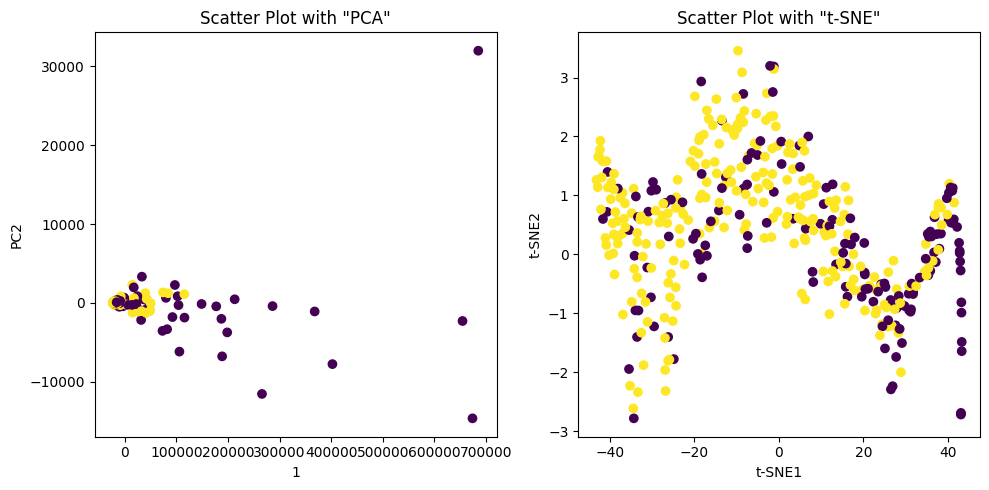

In [ ]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(feas_array)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(feas_array)

# Plotting the reduced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=test_label)
ax1.set_title('Scatter Plot with "PCA"')
ax1.set_xlabel('1')
ax1.set_ylabel('PC2')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=test_label)
ax2.set_title('Scatter Plot with "t-SNE"')
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## left leg

In [ ]:
div = 2219
batch_size=64
left_label = all_label[:div]
# Instantiate data Sequences for each split left leg
left_generator = Features(action_seq[:div], left_label, batch_size)

In [ ]:
feas = []
betas = []
test_acc_metric = keras.metrics.CategoricalAccuracy()
for x_batch_test, y_batch_test in left_generator:
  feature, beta, score = sag(x_batch_test, training=False)
  feas.append(feature)
  betas.append(beta)
  test_acc_metric.update_state(y_batch_test, score)
test_acc = test_acc_metric.result()
print("Test acc: %.4f" % (float(test_acc),))
test_acc_metric.reset_states()
feas_array = np.concatenate(feas, axis=0)
betas_array = np.concatenate(betas, axis=0)


Test acc: 0.4096


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
knn.fit(feas_array[:800] ,left_label[:800])
knn.score(feas_array[800:],left_label[800:])

0.6039464411557435

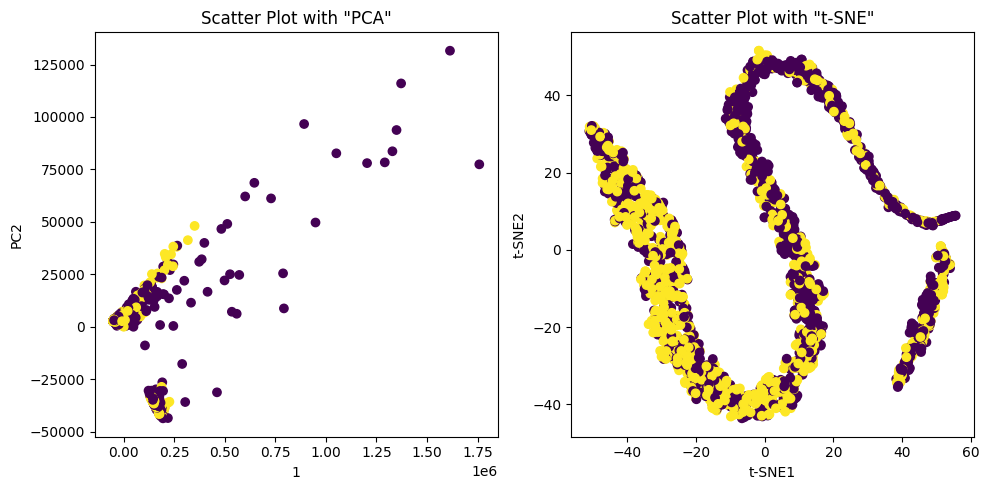

In [ ]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(feas_array)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(feas_array)

# Plotting the reduced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=left_label)
ax1.set_title('Scatter Plot with "PCA"')
ax1.set_xlabel('1')
ax1.set_ylabel('PC2')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=left_label)
ax2.set_title('Scatter Plot with "t-SNE"')
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## right leg

In [ ]:
right_label = all_label[div:]

# Instantiate data Sequences for each split left leg
right_generator = Features(action_seq[div:], right_label, batch_size)

In [ ]:
feas = []
betas = []
test_acc_metric = keras.metrics.CategoricalAccuracy()
for x_batch_test, y_batch_test in right_generator:
  feature, beta, score = sag(x_batch_test, training=False)
  feas.append(feature)
  betas.append(beta)
  test_acc_metric.update_state(y_batch_test, score)
test_acc = test_acc_metric.result()
print("Test acc: %.4f" % (float(test_acc),))
test_acc_metric.reset_states()
feas_array = np.concatenate(feas, axis=0)
betas_array = np.concatenate(betas, axis=0)

Test acc: 0.4083


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
knn.fit(feas_array[:800] ,right_label[:800])
knn.score(feas_array[800:],right_label[800:])

0.5602536997885835

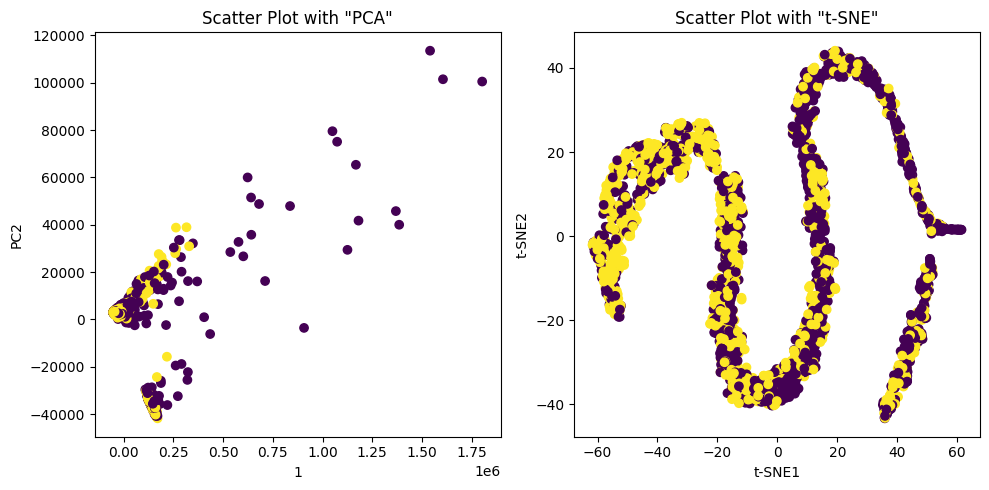

In [ ]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(feas_array)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(feas_array)

# Plotting the reduced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=right_label)
ax1.set_title('Scatter Plot with "PCA"')
ax1.set_xlabel('1')
ax1.set_ylabel('PC2')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=right_label)
ax2.set_title('Scatter Plot with "t-SNE"')
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()